# Marketing Analytics 
Aims to build a model that can predict whether a user opens the emails sent by Shopee.
1. Import 3 datasets
2. One-hot encoding data_train on country, date, and domain columns
3. Remove noise on open_count, login_count, checkout_count based on last open 
4. Merge user dataset to data_train
5. Splitting data for modeling
6. Perform classification using random forest, and neural network (tune the parameter) 
7. Validate the models, and choose the best one
8. Prepare data_test, apply data pre-processing just like the data_train, and merge to dataset
8. Apply the best model (random forest) on data_test
9. Save the classification prediction result


**Source** - https://www.kaggle.com/c/open-shopee-code-league-marketing-analytics/overview

In [ ]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
%cd "My Drive/Marketing Analytics/"

/gdrive/My Drive/Marketing Analytics


## Importing Data & General Inspection

In [ ]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_users = pd.read_csv("users.csv")

In [ ]:
df_train.head()

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id
0,4,2019-07-16 00:00:00+08:00,43,44,19,6,18,0,2,4,12,43,99,0,5,10,0,0
1,4,2019-07-16 00:00:00+08:00,102,44,9,4,8,2,9,17,18,48,90,1,1,4,1,1
2,6,2019-07-16 00:00:00+08:00,177,49,14,5,5,0,4,12,24,69,119,5,19,27,0,2
3,1,2019-07-16 00:00:00+08:00,184,49,49,9,53,0,0,1,9,23,69,1,3,6,0,3
4,6,2019-07-16 00:00:00+08:00,221,49,227,6,221,0,0,0,2,5,5,0,0,0,0,4


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73539 entries, 0 to 73538
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country_code                 73539 non-null  int64 
 1   grass_date                   73539 non-null  object
 2   user_id                      73539 non-null  int64 
 3   subject_line_length          73539 non-null  int64 
 4   last_open_day                73539 non-null  object
 5   last_login_day               73539 non-null  object
 6   last_checkout_day            73539 non-null  object
 7   open_count_last_10_days      73539 non-null  int64 
 8   open_count_last_30_days      73539 non-null  int64 
 9   open_count_last_60_days      73539 non-null  int64 
 10  login_count_last_10_days     73539 non-null  int64 
 11  login_count_last_30_days     73539 non-null  int64 
 12  login_count_last_60_days     73539 non-null  int64 
 13  checkout_count_last_10_days  73

In [ ]:
df_train.describe()

,country_code,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id
count,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.000000,73539.00000
mean,2.533159,63048.595358,43.656373,0.911829,2.780457,5.019364,8.382287,25.284053,49.010430,0.909898,2.796040,5.420960,0.155781,36769.00000
std,1.675251,36068.006037,11.219323,1.754052,4.570239,7.902313,13.424436,37.853189,71.819327,2.887416,7.686064,13.980182,0.362650,21229.02506
min,1.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,31679.500000,34.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,18384.50000
50%,2.000000,63340.000000,43.000000,0.000000,1.000000,2.000000,3.000000,11.000000,22.000000,0.000000,0.000000,1.000000,0.000000,36769.00000
75%,3.000000,94731.500000,52.000000,1.000000,3.000000,6.000000,12.000000,35.000000,69.000000,1.000000,3.000000,6.000000,0.000000,55153.50000
max,7.000000,127925.000000,75.000000,31.000000,92.000000,135.000000,254.000000,735.000000,1260.000000,157.000000,531.000000,783.000000,1.000000,73538.00000


In [ ]:
cnt = df_train['open_flag'].value_counts()

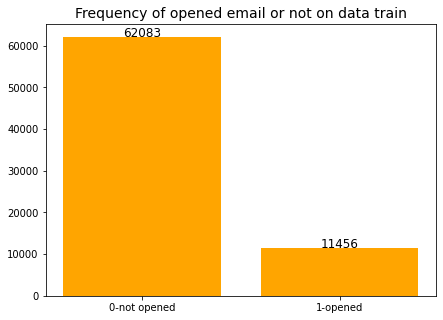

In [ ]:
plt.figure(figsize=(7,5))
x = ['0-not opened','1-opened']
y = []
for i in cnt:
  y.append(i)
plt.bar(x,y, color='orange')
plt.title('Frequency of opened email or not on data train', fontsize=14)
for index,data in enumerate(y):
    plt.text(x=index , y =data , s=f"{data}" , fontdict=dict(fontsize=12), ha='center')
plt.show()

In [ ]:
df_users.head()

,user_id,attr_1,attr_2,attr_3,age,domain
0,0,NaN,1.0,0.0,NaN,@gmail.com
1,1,1.0,1.0,2.0,50.0,@gmail.com
2,2,NaN,1.0,0.0,NaN,other
3,3,NaN,1.0,0.0,NaN,@gmail.com
4,4,1.0,1.0,2.0,33.0,@gmail.com


In [ ]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127886 entries, 0 to 127885
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  127886 non-null  int64  
 1   attr_1   78987 non-null   float64
 2   attr_2   127439 non-null  float64
 3   attr_3   127886 non-null  float64
 4   age      78987 non-null   float64
 5   domain   127886 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 5.9+ MB


In [ ]:
df_users.describe()

,user_id,attr_1,attr_2,attr_3,age
count,127886.000000,78987.000000,127439.000000,127886.000000,78987.000000
mean,63961.168760,0.999823,0.998007,1.079782,31.370124
std,36928.842572,0.013312,0.044600,1.035413,11.591752
min,0.000000,0.000000,0.000000,0.000000,-17.000000
25%,31981.250000,1.000000,1.000000,0.000000,24.000000
50%,63958.500000,1.000000,1.000000,1.000000,29.000000
75%,95941.750000,1.000000,1.000000,2.000000,36.000000
max,127925.000000,1.000000,1.000000,4.000000,118.000000


In [ ]:
df_users.isna().sum()

user_id        0
attr_1     48899
attr_2       447
attr_3         0
age        48899
domain         0
dtype: int64

(array([2.0000e+00, 4.2400e+02, 7.3400e+02, 3.1655e+04, 3.2773e+04,
        1.0792e+04, 1.7420e+03, 3.1400e+02, 4.1000e+01, 1.1000e+01,
        1.9000e+01, 4.8000e+02]),
 array([-17.  ,  -5.75,   5.5 ,  16.75,  28.  ,  39.25,  50.5 ,  61.75,
         73.  ,  84.25,  95.5 , 106.75, 118.  ]),
 <a list of 12 Patch objects>)

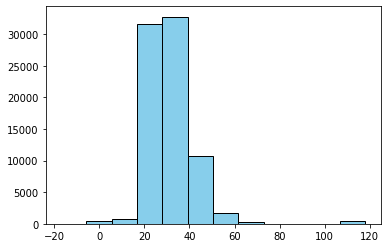

In [ ]:
plt.hist(df_users['age'], bins=12, color="skyblue", edgecolor="black")
#gonna drop age column since the data isn't relevant

In [ ]:
df_users['age'].value_counts()

 25.0     4064
 24.0     3968
 26.0     3962
 27.0     3942
 28.0     3872
          ... 
 108.0       1
 99.0        1
-16.0        1
 91.0        1
 117.0       1
Name: age, Length: 106, dtype: int64

In [ ]:
df_test.describe()

,country_code,user_id,subject_line_length,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,row_id
count,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.000000,55970.00000
mean,2.835215,65049.007790,42.212703,0.774272,2.441880,5.323530,8.978899,26.289459,50.713882,1.124674,3.219385,5.933893,27984.50000
std,1.728489,37934.945847,12.276136,1.752984,4.786883,9.053473,13.975840,38.572656,73.289199,3.500704,8.197445,14.233715,16157.29162
min,1.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,32293.250000,35.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,13992.25000
50%,3.000000,64683.000000,41.000000,0.000000,0.000000,2.000000,4.000000,13.000000,25.000000,0.000000,1.000000,2.000000,27984.50000
75%,4.000000,97776.500000,48.000000,1.000000,3.000000,6.000000,13.000000,36.000000,70.000000,1.000000,3.000000,7.000000,41976.75000
max,7.000000,127922.000000,79.000000,30.000000,79.000000,120.000000,329.000000,746.000000,1300.000000,252.000000,404.000000,609.000000,55969.00000


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55970 entries, 0 to 55969
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country_code                 55970 non-null  int64 
 1   grass_date                   55970 non-null  object
 2   user_id                      55970 non-null  int64 
 3   subject_line_length          55970 non-null  int64 
 4   last_open_day                55970 non-null  object
 5   last_login_day               55970 non-null  object
 6   last_checkout_day            55970 non-null  object
 7   open_count_last_10_days      55970 non-null  int64 
 8   open_count_last_30_days      55970 non-null  int64 
 9   open_count_last_60_days      55970 non-null  int64 
 10  login_count_last_10_days     55970 non-null  int64 
 11  login_count_last_30_days     55970 non-null  int64 
 12  login_count_last_60_days     55970 non-null  int64 
 13  checkout_count_last_10_days  55

## Pre-processing dataset train





In [ ]:
#create a new data frame for feature engineering 

#Apply one-hot encoding for the country code column
df = df_train[['country_code']].copy()
encoded_columns = pd.get_dummies(df['country_code'])
df = df.join(encoded_columns).drop('country_code', axis=1)

#Extract info on the weekday date and month that the grass date is on
df['weekday_date'] = pd.to_datetime(df_train.grass_date).dt.day_name()
df['month'] = pd.to_datetime(df_train.grass_date).dt.month

#Include the subject line length
df['subject_line_length']=df_train['subject_line_length'].copy()

# To convert the last open day into integer type and for last open day, it is set as 0
df['last_open_day'] = df_train.last_open_day.apply(lambda x: 1000 if x =='Never open' else x)
df['last_open_day']=df['last_open_day'].astype(str).astype(int)

# To convert the last login day into integer type 
df['last_login_day'] = df_train.last_login_day.apply(lambda x: 20000 if x =='Never login' else x)
df['last_login_day'] = df['last_login_day'].astype(str).astype(int)

# To convert the last checkout day into integer type 
df['last_checkout_day'] = df_train.last_checkout_day.apply(lambda x: 1500 if x =='Never checkout' else x)
df['last_checkout_day'] = df['last_checkout_day'].astype(str).astype(int)

df.head(5)

,1,2,3,4,5,6,7,weekday_date,month,subject_line_length,last_open_day,last_login_day,last_checkout_day
0,0,0,0,1,0,0,0,Tuesday,7,44,19,6,18
1,0,0,0,1,0,0,0,Tuesday,7,44,9,4,8
2,0,0,0,0,0,1,0,Tuesday,7,49,14,5,5
3,1,0,0,0,0,0,0,Tuesday,7,49,49,9,53
4,0,0,0,0,0,1,0,Tuesday,7,49,227,6,221


In [ ]:
df.head()

,1,2,3,4,5,6,7,weekday_date,month,subject_line_length,last_open_day,last_login_day,last_checkout_day
0,0,0,0,1,0,0,0,Tuesday,7,44,19,6,18
1,0,0,0,1,0,0,0,Tuesday,7,44,9,4,8
2,0,0,0,0,0,1,0,Tuesday,7,49,14,5,5
3,1,0,0,0,0,0,0,Tuesday,7,49,49,9,53
4,0,0,0,0,0,1,0,Tuesday,7,49,227,6,221


In [ ]:
#remove noise in open count last 10/30/60 days

#set those that are last open more than 10 days ago as 0 under open_count_last_10_days
df['open_count_last_10_days'] = df_train['open_count_last_10_days'].copy()
df['open_count_last_10_days'] = df.apply(lambda x: 0 if (x['last_open_day'] > 10) else x['open_count_last_10_days'],axis =1)

df['open_count_last_30_days'] = df_train['open_count_last_30_days'].copy()
df['open_count_last_30_days'] = df.apply(lambda x: 0 if (x['last_open_day'] > 30) else x['open_count_last_30_days'],axis =1)
df['open_count_last_60_days'] = df_train['open_count_last_60_days'].copy()
df['open_count_last_60_days'] = df.apply(lambda x: 0 if (x['last_open_day'] > 60) else x['open_count_last_60_days'],axis =1)

In [ ]:
df['open_count_last_10_days'] = df.apply(lambda x: 1 if ((x['last_open_day'] <= 10) & (x['open_count_last_10_days']==0)) else x['open_count_last_10_days'],axis=1)
df['open_count_last_30_days'] = df.apply(lambda x: 1 if ((x['last_open_day'] <= 30) & (x['open_count_last_30_days']==0)) else x['open_count_last_30_days'],axis =1)
df['open_count_last_60_days'] = df.apply(lambda x: 1 if ((x['last_open_day'] <= 60) & (x['open_count_last_60_days']==0)) else x['open_count_last_60_days'],axis =1)
df.head()

,1,2,3,4,5,6,7,weekday_date,month,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days
0,0,0,0,1,0,0,0,Tuesday,7,44,19,6,18,0,2,4
1,0,0,0,1,0,0,0,Tuesday,7,44,9,4,8,2,9,17
2,0,0,0,0,0,1,0,Tuesday,7,49,14,5,5,0,4,12
3,1,0,0,0,0,0,0,Tuesday,7,49,49,9,53,0,0,1
4,0,0,0,0,0,1,0,Tuesday,7,49,227,6,221,0,0,0


In [ ]:
#remove noise in login count last 10/30/60 days

#set those that are last login more than 10 days ago as 0 under open_count_last_10_days
df['login_count_last_10_days'] = df_train['login_count_last_10_days'].copy()
df['login_count_last_10_days'] = df.apply(lambda x: 0 if (x['last_login_day'] > 10) else x['login_count_last_10_days'],axis =1)
df['login_count_last_30_days'] = df_train['login_count_last_30_days'].copy()
df['login_count_last_30_days'] = df.apply(lambda x: 0 if (x['last_login_day'] > 30) else x['login_count_last_30_days'],axis =1)
df['login_count_last_60_days'] = df_train['login_count_last_60_days'].copy()
df['login_count_last_60_days'] = df.apply(lambda x: 0 if (x['last_login_day'] > 60) else x['login_count_last_60_days'],axis =1)

df['login_count_last_10_days'] = df.apply(lambda x: 1 if ((x['last_login_day'] <= 10) & (x['login_count_last_10_days']==0)) else x['login_count_last_10_days'],axis=1)
df['login_count_last_30_days'] = df.apply(lambda x: 1 if ((x['last_login_day'] <= 30) & (x['login_count_last_30_days']==0)) else x['login_count_last_30_days'],axis =1)
df['login_count_last_60_days'] = df.apply(lambda x: 1 if ((x['last_login_day'] <= 60) & (x['login_count_last_60_days']==0)) else x['login_count_last_60_days'],axis =1)

df.head()

,1,2,3,4,5,6,7,weekday_date,month,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days
0,0,0,0,1,0,0,0,Tuesday,7,44,19,6,18,0,2,4,12,43,99
1,0,0,0,1,0,0,0,Tuesday,7,44,9,4,8,2,9,17,18,48,90
2,0,0,0,0,0,1,0,Tuesday,7,49,14,5,5,0,4,12,24,69,119
3,1,0,0,0,0,0,0,Tuesday,7,49,49,9,53,0,0,1,9,23,69
4,0,0,0,0,0,1,0,Tuesday,7,49,227,6,221,0,0,0,2,5,5


In [ ]:
df['checkout_count_last_10_days'] = df_train['checkout_count_last_10_days'].copy()
df['checkout_count_last_30_days'] = df_train['checkout_count_last_30_days'].copy()
df['checkout_count_last_60_days'] = df_train['checkout_count_last_60_days'].copy()

In [ ]:
# remove noise in checkout count last 10/30/60 days

# set those that are last checkout more than 10 days ago as 0 under open_count_last_10_days
df['checkout_count_last_10_days'] = df.apply(lambda x: 0 if (x['last_checkout_day'] > 10) else x['checkout_count_last_10_days'],axis =1)
df['checkout_count_last_30_days'] = df.apply(lambda x: 0 if (x['last_checkout_day'] > 30) else x['checkout_count_last_30_days'],axis =1)
df['checkout_count_last_60_days'] = df.apply(lambda x: 0 if (x['last_checkout_day'] > 60) else x['checkout_count_last_60_days'],axis =1)

df['checkout_count_last_10_days'] = df.apply(lambda x: 1 if ((x['last_checkout_day'] <= 10) & (x['checkout_count_last_10_days']==0)) else x['checkout_count_last_10_days'],axis=1)
df['checkout_count_last_30_days'] = df.apply(lambda x: 1 if ((x['last_checkout_day'] <= 30) & (x['checkout_count_last_30_days']==0)) else x['checkout_count_last_30_days'],axis =1)
df['checkout_count_last_60_days'] = df.apply(lambda x: 1 if ((x['last_checkout_day'] <= 60) & (x['checkout_count_last_60_days']==0)) else x['checkout_count_last_60_days'],axis =1)

df.head()

,1,2,3,4,5,6,7,weekday_date,month,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days
0,0,0,0,1,0,0,0,Tuesday,7,44,19,6,18,0,2,4,12,43,99,0,5,10
1,0,0,0,1,0,0,0,Tuesday,7,44,9,4,8,2,9,17,18,48,90,1,1,4
2,0,0,0,0,0,1,0,Tuesday,7,49,14,5,5,0,4,12,24,69,119,5,19,27
3,1,0,0,0,0,0,0,Tuesday,7,49,49,9,53,0,0,1,9,23,69,0,0,6
4,0,0,0,0,0,1,0,Tuesday,7,49,227,6,221,0,0,0,2,5,5,0,0,0


## Processing df_users & merge with df_train

In [ ]:
df_users.isna().sum()

user_id        0
attr_1     48899
attr_2       447
attr_3         0
age        48899
domain         0
dtype: int64

In [ ]:
df['user_id']= df_train['user_id'].copy()
df['open_flag']=df_train['open_flag'].copy()

#merge
data_train = pd.merge(left=df, right=df_users, left_on='user_id', right_on='user_id')

In [ ]:
# Apply one-hot encoding for the domain column
encoded_columns = pd.get_dummies(data_train ['domain'])
data_train  = data_train.join(encoded_columns).drop('domain', axis=1)

# Apply one-hot encoding for the weekday date column
encoded_columns = pd.get_dummies(data_train['weekday_date'])
data_train = data_train.join(encoded_columns).drop('weekday_date', axis=1)

#-1 assigned for missing data
data_train ['attr_1']= data_train['attr_1'].fillna(-1)
data_train ['attr_2']= data_train['attr_2'].fillna(-1)

In [ ]:
data_train.head()

,1,2,3,4,5,6,7,month,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,user_id,open_flag,attr_1,attr_2,attr_3,age,@163.com,@gmail.com,@hotmail.com,@icloud.com,@live.com,@outlook.com,@qq.com,@rocketmail.com,@yahoo.com,@ymail.com,other,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,1,0,0,0,7,44,19,6,18,0,2,4,12,43,99,0,5,10,43,0,1.0,1.0,2.0,47.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,7,44,9,4,8,2,9,17,18,48,90,1,1,4,102,1,1.0,1.0,2.0,25.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,7,49,14,5,5,0,4,12,24,69,119,5,19,27,177,0,-1.0,1.0,0.0,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,7,49,49,9,53,0,0,1,9,23,69,0,0,6,184,0,1.0,1.0,2.0,24.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,7,49,227,6,221,0,0,0,2,5,5,0,0,0,221,0,-1.0,1.0,0.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#delete columns (unnecessary for prediction)
data_train.drop(['user_id','age'], axis = 1, inplace = True)

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73539 entries, 0 to 73538
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   1                            73539 non-null  uint8  
 1   2                            73539 non-null  uint8  
 2   3                            73539 non-null  uint8  
 3   4                            73539 non-null  uint8  
 4   5                            73539 non-null  uint8  
 5   6                            73539 non-null  uint8  
 6   7                            73539 non-null  uint8  
 7   month                        73539 non-null  int64  
 8   subject_line_length          73539 non-null  int64  
 9   last_open_day                73539 non-null  int64  
 10  last_login_day               73539 non-null  int64  
 11  last_checkout_day            73539 non-null  int64  
 12  open_count_last_10_days      73539 non-null  int64  
 13  open_count_last_

## Prediction and testing on data_train

In [ ]:
from sklearn.model_selection import train_test_split

# separate the independent and target variable 
train_X = data_train.drop(columns=['open_flag'])
test_X = data_train['open_flag']

# randomly split the data
x_train, x_test, y_train, y_test = train_test_split(train_X, test_X,test_size=0.3,random_state=0)

# shape of train and test splits
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((51477, 42), (22062, 42), (51477,), (22062,))

### Random Forest

In [ ]:
#tuning parameters
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'max_depth': [40, 50, 60],
    'n_estimators': [100, 150, 200], 
} 

# Create a based model
rf = RandomForestClassifier(class_weight = {0:5, 1:1}, max_features='auto', criterion= 'gini')  
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(x_train,y_train)
grid_search.best_params_


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.3min finished


{'max_depth': 50, 'n_estimators': 200}

In [ ]:
best_gridrf = grid_search.best_estimator_
best_gridrf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 5, 1: 1},
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn import metrics

print("Accuracy Train:   ", best_gridrf.score(x_train,y_train))
print("Accuracy Test:   ", best_gridrf.score(x_test,y_test))

y_pred = best_gridrf.predict(x_test)
y_true = y_test

#f1 score
f1_rf = metrics.f1_score(y_true, y_pred, average='weighted')
print("F Score:   ", f1_rf)

#mcc score
from sklearn.metrics import matthews_corrcoef
print("MCC:   ", matthews_corrcoef(y_true, y_pred))

Accuracy Train:    0.9999028692425743
Accuracy Test:    0.8888133442117668
F Score:    0.8784884059991067
MCC:    0.5239688834357776


In [ ]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

Text(0.5, 1.0, 'Confusion Matrix Model Random Forest')

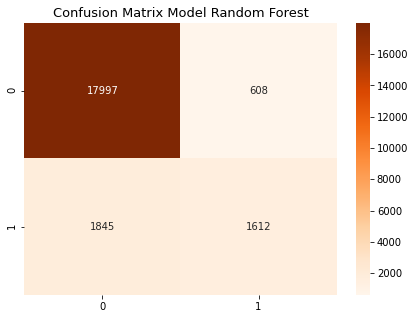

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.heatmap(cf_matrix, annot=True, 
            fmt='', cmap='Oranges')
plt.title("Confusion Matrix Model Random Forest", fontsize=13)

### Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

param_nn = {
    'hidden_layer_sizes': [(100), (150)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.001, 0.002],
    'learning_rate': ['constant','adaptive'],
}

# Create a based model
nn = MLPClassifier(solver='adam', max_iter=200) 
# Instantiate the grid search model
grid_searchnn = GridSearchCV(estimator = nn, param_grid = param_nn, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_searchnn.fit(x_train,y_train)
grid_searchnn.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 20.4min finished


{'activation': 'relu',
 'alpha': 0.002,
 'hidden_layer_sizes': 150,
 'learning_rate': 'constant'}

In [ ]:
best_gridnn = grid_searchnn.best_estimator_
best_gridnn

MLPClassifier(activation='relu', alpha=0.002, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=150, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
print("Accuracy Train:   ", best_gridnn.score(x_train,y_train))
print("Accuracy Test:   ", best_gridnn.score(x_test,y_test))

y_pred = best_gridnn.predict(x_test)
y_true = y_test

#f1 score
f1_rf = metrics.f1_score(y_true, y_pred, average='weighted')
print("F Score:   ", f1_rf)

#mcc score
print("MCC:   ", matthews_corrcoef(y_true, y_pred))

Accuracy Train:    0.8878528274763486
Accuracy Test:    0.882558244946061
F Score:    0.8657751110864476
MCC:    0.47672615187408285


In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[18167   438]
 [ 2153  1304]]


Text(0.5, 1.0, 'Confusion Matrix Model Neural Network')

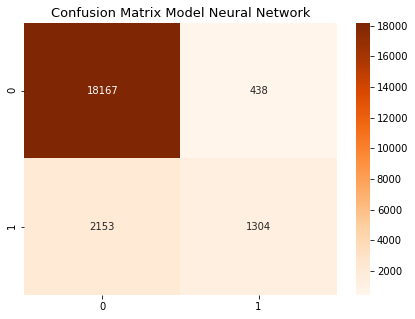

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.heatmap(cf_matrix, annot=True, 
            fmt='', cmap='Oranges')
plt.title("Confusion Matrix Model Neural Network", fontsize=13)

## Processing df_test
1. One-hot encoding
2. Remove noise

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55970 entries, 0 to 55969
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country_code                 55970 non-null  int64 
 1   grass_date                   55970 non-null  object
 2   user_id                      55970 non-null  int64 
 3   subject_line_length          55970 non-null  int64 
 4   last_open_day                55970 non-null  object
 5   last_login_day               55970 non-null  object
 6   last_checkout_day            55970 non-null  object
 7   open_count_last_10_days      55970 non-null  int64 
 8   open_count_last_30_days      55970 non-null  int64 
 9   open_count_last_60_days      55970 non-null  int64 
 10  login_count_last_10_days     55970 non-null  int64 
 11  login_count_last_30_days     55970 non-null  int64 
 12  login_count_last_60_days     55970 non-null  int64 
 13  checkout_count_last_10_days  55

In [ ]:
#create a new data frame for feature engineering 

#Apply one-hot encoding for the country code column
dftest = df_test[['country_code']].copy()
encoded_columns = pd.get_dummies(dftest['country_code'])
dftest = dftest.join(encoded_columns).drop('country_code', axis=1)

#Extract info on the weekday date and month that the grass date is on
dftest['weekday_date'] = pd.to_datetime(df_test.grass_date).dt.day_name()
dftest['month'] = pd.to_datetime(df_test.grass_date).dt.month

#Include the subject line length
dftest['subject_line_length'] = df_test['subject_line_length'].copy()

# To convert the last open day into integer type and for last open day, it is set as 0
dftest['last_open_day'] = df_test.last_open_day.apply(lambda x: 1000 if x =='Never open' else x)
dftest['last_open_day'] = dftest['last_open_day'].astype(str).astype(int)

# To convert the last login day into integer type 
dftest['last_login_day'] = df_test.last_login_day.apply(lambda x: 20000 if x =='Never login' else x)
dftest['last_login_day'] = dftest['last_login_day'].astype(str).astype(int)

# To convert the last checkout day into integer type 
dftest['last_checkout_day'] = df_test.last_checkout_day.apply(lambda x: 1500 if x =='Never checkout' else x)
dftest['last_checkout_day'] = dftest['last_checkout_day'].astype(str).astype(int)

df.head(5)

,1,2,3,4,5,6,7,weekday_date,month,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,user_id,open_flag
0,0,0,0,1,0,0,0,Tuesday,7,44,19,6,18,0,2,4,12,43,99,0,5,10,43,0
1,0,0,0,1,0,0,0,Tuesday,7,44,9,4,8,2,9,17,18,48,90,1,1,4,102,1
2,0,0,0,0,0,1,0,Tuesday,7,49,14,5,5,0,4,12,24,69,119,5,19,27,177,0
3,1,0,0,0,0,0,0,Tuesday,7,49,49,9,53,0,0,1,9,23,69,0,0,6,184,0
4,0,0,0,0,0,1,0,Tuesday,7,49,227,6,221,0,0,0,2,5,5,0,0,0,221,0


In [ ]:
#remove noise in open count last 10/30/60 days

#set those that are last open more than 10 days ago as 0 under open_count_last_10_days
dftest['open_count_last_10_days'] = df_test['open_count_last_10_days'].copy()
dftest['open_count_last_10_days'] = dftest.apply(lambda x: 0 if (x['last_open_day'] > 10) else x['open_count_last_10_days'],axis =1)

dftest['open_count_last_30_days'] = df_test['open_count_last_30_days'].copy()
dftest['open_count_last_30_days'] = dftest.apply(lambda x: 0 if (x['last_open_day'] > 30) else x['open_count_last_30_days'],axis =1)
dftest['open_count_last_60_days'] = df_test['open_count_last_60_days'].copy()
dftest['open_count_last_60_days'] = dftest.apply(lambda x: 0 if (x['last_open_day'] > 60) else x['open_count_last_60_days'],axis =1)

In [ ]:
dftest['open_count_last_10_days'] = dftest.apply(lambda x: 1 if ((x['last_open_day'] <= 10) & (x['open_count_last_10_days']==0)) else x['open_count_last_10_days'],axis=1)
dftest['open_count_last_30_days'] = dftest.apply(lambda x: 1 if ((x['last_open_day'] <= 30) & (x['open_count_last_30_days']==0)) else x['open_count_last_30_days'],axis =1)
dftest['open_count_last_60_days'] = dftest.apply(lambda x: 1 if ((x['last_open_day'] <= 60) & (x['open_count_last_60_days']==0)) else x['open_count_last_60_days'],axis =1)
dftest.head()

,1,2,3,4,5,6,7,weekday_date,month,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days
0,0,0,0,0,0,1,0,Tuesday,9,35,27,2,13,0,3,4
1,0,0,0,0,0,1,0,Tuesday,9,35,7,5,383,1,1,1
2,0,0,0,0,1,0,0,Tuesday,9,25,34,1,3,0,0,1
3,1,0,0,0,0,0,0,Tuesday,9,36,63,5,5,0,0,0
4,0,0,0,0,1,0,0,Tuesday,9,23,6,5,54,1,1,1


In [ ]:
#remove noise in login count last 10/30/60 days

#set those that are last login more than 10 days ago as 0 under open_count_last_10_days
dftest['login_count_last_10_days'] = df_test['login_count_last_10_days'].copy()
dftest['login_count_last_10_days'] = dftest.apply(lambda x: 0 if (x['last_login_day'] > 10) else x['login_count_last_10_days'],axis =1)
dftest['login_count_last_30_days'] = df_test['login_count_last_30_days'].copy()
dftest['login_count_last_30_days'] = dftest.apply(lambda x: 0 if (x['last_login_day'] > 30) else x['login_count_last_30_days'],axis =1)
dftest['login_count_last_60_days'] = df_test['login_count_last_60_days'].copy()
dftest['login_count_last_60_days'] = dftest.apply(lambda x: 0 if (x['last_login_day'] > 60) else x['login_count_last_60_days'],axis =1)

dftest['login_count_last_10_days'] = dftest.apply(lambda x: 1 if ((x['last_login_day'] <= 10) & (x['login_count_last_10_days']==0)) else x['login_count_last_10_days'],axis=1)
dftest['login_count_last_30_days'] = dftest.apply(lambda x: 1 if ((x['last_login_day'] <= 30) & (x['login_count_last_30_days']==0)) else x['login_count_last_30_days'],axis =1)
dftest['login_count_last_60_days'] = dftest.apply(lambda x: 1 if ((x['last_login_day'] <= 60) & (x['login_count_last_60_days']==0)) else x['login_count_last_60_days'],axis =1)

dftest.head()

,1,2,3,4,5,6,7,weekday_date,month,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days
0,0,0,0,0,0,1,0,Tuesday,9,35,27,2,13,0,3,4,10,34,134
1,0,0,0,0,0,1,0,Tuesday,9,35,7,5,383,1,1,1,5,5,5
2,0,0,0,0,1,0,0,Tuesday,9,25,34,1,3,0,0,1,13,19,38
3,1,0,0,0,0,0,0,Tuesday,9,36,63,5,5,0,0,0,43,110,173
4,0,0,0,0,1,0,0,Tuesday,9,23,6,5,54,1,1,1,4,12,39


In [ ]:
dftest['checkout_count_last_10_days'] = df_test['checkout_count_last_10_days'].copy()
dftest['checkout_count_last_30_days'] = df_test['checkout_count_last_30_days'].copy()
dftest['checkout_count_last_60_days'] = df_test['checkout_count_last_60_days'].copy()

In [ ]:
# remove noise in checkout count last 10/30/60 days

# set those that are last checkout more than 10 days ago as 0 under open_count_last_10_days
dftest['checkout_count_last_10_days'] = dftest.apply(lambda x: 0 if (x['last_checkout_day'] > 10) else x['checkout_count_last_10_days'],axis =1)
dftest['checkout_count_last_30_days'] = dftest.apply(lambda x: 0 if (x['last_checkout_day'] > 30) else x['checkout_count_last_30_days'],axis =1)
dftest['checkout_count_last_60_days'] = dftest.apply(lambda x: 0 if (x['last_checkout_day'] > 60) else x['checkout_count_last_60_days'],axis =1)

dftest['checkout_count_last_10_days'] = dftest.apply(lambda x: 1 if ((x['last_checkout_day'] <= 10) & (x['checkout_count_last_10_days']==0)) else x['checkout_count_last_10_days'],axis=1)
dftest['checkout_count_last_30_days'] = dftest.apply(lambda x: 1 if ((x['last_checkout_day'] <= 30) & (x['checkout_count_last_30_days']==0)) else x['checkout_count_last_30_days'],axis =1)
dftest['checkout_count_last_60_days'] = dftest.apply(lambda x: 1 if ((x['last_checkout_day'] <= 60) & (x['checkout_count_last_60_days']==0)) else x['checkout_count_last_60_days'],axis =1)

dftest.head()

,1,2,3,4,5,6,7,weekday_date,month,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days
0,0,0,0,0,0,1,0,Tuesday,9,35,27,2,13,0,3,4,10,34,134,0,6,18
1,0,0,0,0,0,1,0,Tuesday,9,35,7,5,383,1,1,1,5,5,5,0,0,0
2,0,0,0,0,1,0,0,Tuesday,9,25,34,1,3,0,0,1,13,19,38,2,2,2
3,1,0,0,0,0,0,0,Tuesday,9,36,63,5,5,0,0,0,43,110,173,2,5,5
4,0,0,0,0,1,0,0,Tuesday,9,23,6,5,54,1,1,1,4,12,39,0,0,2


## Merge dfuser to dftest

In [ ]:
dftest['user_id']= df_test['user_id'].copy()
df_test_1 = pd.merge(left=dftest, right=df_users, left_on='user_id', right_on='user_id')

In [ ]:
# Apply one-hot encoding for the domain column
encoded_columns = pd.get_dummies(df_test_1['domain'])
df_test_1 = df_test_1.join(encoded_columns).drop('domain', axis=1)

#-1 assigned for missing data
df_test_1['attr_1']= df_test_1['attr_1'].fillna(-1)
df_test_1['attr_2']= df_test_1['attr_2'].fillna(-1)

# Apply one-hot encoding for the weekday date column
encoded_columns = pd.get_dummies(df_test_1['weekday_date'])
df_test_1 = df_test_1.join(encoded_columns).drop('weekday_date', axis=1)
df_test_1

,1,2,3,4,5,6,7,month,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,user_id,attr_1,attr_2,attr_3,age,@163.com,@gmail.com,@hotmail.com,@icloud.com,@live.com,@outlook.com,@qq.com,@rocketmail.com,@yahoo.com,@ymail.com,other,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,0,0,1,0,9,35,27,2,13,0,3,4,10,34,134,0,6,18,0,-1.0,1.0,0.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,9,35,7,5,383,1,1,1,5,5,5,0,0,0,130,-1.0,1.0,0.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,9,25,34,1,3,0,0,1,13,19,38,2,2,2,150,1.0,1.0,2.0,33.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,9,36,63,5,5,0,0,0,43,110,173,2,5,5,181,1.0,1.0,2.0,22.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,9,23,6,5,54,1,1,1,4,12,39,0,0,2,192,-1.0,1.0,0.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,0,0,0,0,0,1,0,9,53,1000,4,8,0,0,0,1,1,1,1,1,1,127348,-1.0,1.0,0.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
55966,0,0,0,0,0,1,0,9,53,59,802,1207,0,0,1,0,0,0,0,0,0,127396,-1.0,1.0,0.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
55967,0,0,0,0,0,1,0,9,43,1000,7,1500,0,0,0,1,1,1,0,0,0,127574,-1.0,1.0,0.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
55968,0,0,0,0,0,1,0,9,43,5,5,6,2,5,14,1,1,1,1,1,1,127887,-1.0,1.0,0.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
#delete columns (unnecessary for prediction)
df_test_1.drop(['user_id','age'], axis = 1, inplace = True)

## Prediction of dftest

In [ ]:
#USE RANDOM FOREST
predictions = best_gridrf.predict(df_test_1)

In [ ]:
from google.colab import files
columns_titles = ["row_id","open_flag"]
predictions_df = pd.DataFrame(predictions)
predictions_df['row_id'] = predictions_df.index
predictions_df.rename(columns = {0: 'open_flag'}, inplace = True)
predictions_df['open_flag']= predictions_df['open_flag'].astype(int)
predictions_df=predictions_df.reindex(columns=columns_titles)
print(predictions_df)

       row_id  open_flag
0           0          0
1           1          0
2           2          0
3           3          0
4           4          0
...       ...        ...
55965   55965          0
55966   55966          0
55967   55967          0
55968   55968          0
55969   55969          1

[55970 rows x 2 columns]


In [ ]:
cntpred = predictions_df['open_flag'].value_counts()

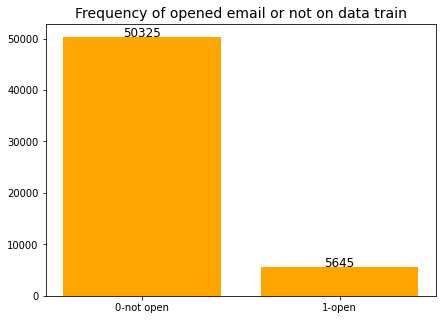

In [ ]:
plt.figure(figsize=(7,5))
x = ['0-not open','1-open']
y = []
for i in cntpred:
  y.append(i)
plt.bar(x,y, color='orange')
plt.title('Frequency of opened email or not on data train', fontsize=14)
for index,data in enumerate(y):
    plt.text(x=index , y =data , s=f"{data}" , fontdict=dict(fontsize=12), ha='center')
plt.show()

In [ ]:
filename = 'hasilprediksi.csv'
predictions_df.to_csv(filename, index=False)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>